In [1]:
!pip install -q pytorchvideo transformers evaluate

> # **Data Collection and Aggregation**

In [2]:
import os
import pandas as pd

root_path = "/kaggle/input/real-time-anomaly-detection-in-cctv-surveillance/data/"
folder_list = os.listdir(root_path)
label_list = [path for path in folder_list if not path.endswith((".csv"))]

train_df = pd.read_csv(os.path.join(root_path,"train.csv"))
test_df = pd.read_csv(os.path.join(root_path,"test.csv"))

selected_cols = ['label', 'video_name']
train_df = train_df[selected_cols]
test_df = test_df[selected_cols]

total_df = pd.concat([train_df, test_df])
total_df.reset_index(drop = True, inplace = True)
total_df['label'].value_counts()

label
normal           950
roadaccidents    150
robbery          150
stealing         100
burglary         100
explosion         50
fighting          50
vandalism         50
shoplifting       50
arrest            50
assault           50
shooting          50
arson             50
abuse             50
Name: count, dtype: int64

> # **Data Splitting**

In [3]:
from sklearn.model_selection import train_test_split

def correct_file_path(file_name: str, root_path: str):
    root_path = "/kaggle/input/real-time-anomaly-detection-in-cctv-surveillance/"
    return os.path.join(root_path, file_name.replace('\\', '/'))

def preprocess_meta_df(df, root_path, label2id):
    df.rename(columns={"video_name": "video_path"}, inplace=True)
    df['video_path'] = df['video_path'].apply(lambda x: correct_file_path(x, root_path))
    df['label'] = df['label'].apply(lambda x: label2id[x])
    return df

selected_labels = ['normal', 'abuse', 'arson', 'burglary', 'explosion', 'roadaccidents', 'shooting']
total_df = total_df[total_df['label'].isin(selected_labels)]

sampling_meta_df, _ = train_test_split(total_df, test_size=0.1, stratify=total_df['label'], random_state=42)
train_meta_df, test_meta_df = train_test_split(sampling_meta_df, test_size=0.2, stratify=sampling_meta_df['label'], random_state=42)
test_meta_df, eval_meta_df = train_test_split(test_meta_df, test_size=0.1, stratify=test_meta_df['label'], random_state=42)

label_list = list(set(train_meta_df['label']))
class_labels = sorted(label_list)
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

train_meta_df = preprocess_meta_df(train_meta_df, root_path, label2id)
eval_meta_df = preprocess_meta_df(eval_meta_df, root_path, label2id)
test_meta_df = preprocess_meta_df(test_meta_df, root_path, label2id)

print("Splitted data:", len(train_meta_df), len(test_meta_df), len(eval_meta_df))

Unique classes: ['abuse', 'arson', 'burglary', 'explosion', 'normal', 'roadaccidents', 'shooting'].
Splitted data: 1008 226 26


> #  **Model Selection and Design**

In [4]:
import torch
import pytorchvideo.data
from torch.utils.data import Dataset
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import VivitImageProcessor, VivitModel, VivitForVideoClassification

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

model_checkpoint = "google/vivit-b-16x2-kinetics400"
image_processor = VivitImageProcessor.from_pretrained(model_checkpoint)
model = VivitForVideoClassification.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True)

2025-04-28 19:25:44.437549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 19:25:44.437659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 19:25:44.634940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


> # **Data Preprocessing and Cleaning**

In [5]:
class CustomVideoDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        video_path = row['video_path']
        label = row['label']
        return video_path, label

mean = image_processor.image_mean
std = image_processor.image_std

if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]

resize_to = (model.config.image_size, model.config.image_size)

num_frames_to_sample = model.config.num_frames
sample_rate = 20
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    Resize(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

train_custom_dataset = CustomVideoDataset(train_meta_df)
train_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in train_custom_dataset]

eval_custom_dataset = CustomVideoDataset(eval_meta_df)
eval_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in eval_custom_dataset]

test_custom_dataset = CustomVideoDataset(test_meta_df)
test_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in test_custom_dataset]

> # **Data Loading**

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


normal


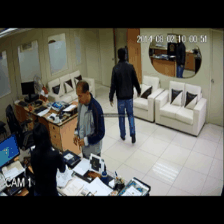

In [6]:
import imageio
import numpy as np
from IPython.display import Image

train_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =train_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

val_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =eval_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =test_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

def unnormalize_img(img):
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.5}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
print(id2label[sample_video['label']])
display_gif(video_tensor)

> # **Model and Data Preparation**

In [7]:
from transformers import TrainingArguments, Trainer

model_name = model_checkpoint.split("/")[-1]
new_model_name = f"{model_name}-finetuned-cctv-surveillance"
num_epochs = 4
batch_size = 1

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

> # **Model Training and Validation**

In [ ]:
import wandb
import evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)
    f1 = f1_metric.compute(predictions=predictions, references=eval_pred.label_ids, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=eval_pred.label_ids, average='weighted')
    precision = precision_metric.compute(predictions=predictions, references=eval_pred.label_ids, average='weighted')
    combined_metrics = {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "recall": recall["recall"],
        "precision": precision["precision"]
    }
    return combined_metrics

def collate_fn(examples):
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

train_results = trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
0,1.313800,0.376653,0.917647,0.880941,0.917647,0.847059


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  w

> # **Model Testing**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(trainer, dataset):
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    return preds, predictions.label_ids

y_pred, y_true = get_predictions(trainer, test_dataset)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

> # **Model Evaluation**

In [ ]:
results = trainer.evaluate()
print(results)

> # **Model Deployment**

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer.push_to_hub()